### Á≠ñÁï•2ÔºöÂÉπÂπ≥Á≠ñÁï•

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice
from datetime import datetime, timedelta
import re
import os
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties as font
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei') # Âú®ÂúñË°®‰∏äÈ°ØÁ§∫‰∏≠Êñá
import matplotlib.ticker as mtick
from collections import Counter
import seaborn as sns

In [2]:
df_option_pcp = pd.read_csv(r'D:\CODE\SC_SP_delay_weeklyÁ≠ñÁï•\data\df_new.csv', encoding = 'utf-8-sig')
df_tick = pd.read_csv(r'D:\CODE\SC_SP_delay_weeklyÁ≠ñÁï•\data\df_tick.csv', encoding = 'utf-8-sig')
df_tick_1 = pd.read_csv(r'D:\CODE\SC_SP_delay_weeklyÁ≠ñÁï•\data\df_tick_1.csv', encoding = 'utf-8-sig')
df_new_2 = df_option_pcp.copy()

ÂâçÁΩÆË®≠ÂÆöÔºöÂåÖÂê´ÊâãÁ∫åË≤ª„ÄÅÁ®ÖË®àÁï´„ÄÅÊúÄÁµÇÁ∏æÊïàË®àÁÆóÁ≠âÁ≠â

In [3]:
def calculate_new_price(df_tick, df_new, strike_price_col):
    """
    Ê†πÊìö `df_tick` Â∞ãÊâæÂåπÈÖçÁöÑ `NewPrice`Ôºå‰∏¶Êõ¥Êñ∞ `NewDate`„ÄÅ`NumMatchingTrades`
    
    ÂèÉÊï∏Ôºö
    df_tick: ÈÅ∏ÊìáÊ¨ä‰∫§ÊòìÊï∏Êìö DataFrame
    df_new: PCP Ë®àÁÆóÊï∏Êìö DataFrame
    strike_price_col: ÈúÄË¶ÅÂåπÈÖçÁöÑÂ±•Á¥ÑÂÉπÊ¨Ñ‰Ωç (ÂèØÂÇ≥ 'StrikePrice', 'AtTheMoneyStrikePrice', 'SelectedStrikePrice')
    
    ÂõûÂÇ≥Ôºö
    Êõ¥Êñ∞ÂæåÁöÑ df_new DataFrame
    """
    # **ËΩâÊèõ `df_tick` ÁöÑÊàê‰∫§Êó•ÊúüÊ†ºÂºè**
    df_tick["TradeDate"] = pd.to_datetime(df_tick["Êàê‰∫§Êó•Êúü"].astype(str), format="%Y%m%d").dt.strftime("%Y-%m-%d")

    # **ÂàùÂßãÂåñÊñ∞Ê¨Ñ‰Ωç**
    df_new["NewPrice"] = None
    df_new["NewDate"] = None
    df_new["NumMatchingTrades"] = 0

    # **ÈÅçÊ≠∑ `df_new`**
    for idx, row in df_new.iterrows():
        original_date = row["Date"]
        strike_price = row[strike_price_col]  # **ÂãïÊÖã‰ΩøÁî®‰∏çÂêåÁ≠ñÁï•ÁöÑÂ±•Á¥ÑÂÉπ**
        category = row["Category"]
        product_code = row["ProductCode"]

        # **Â∞ãÊâæÁ¨¶ÂêàÊ¢ù‰ª∂ÁöÑ `df_tick` Êï∏Êìö**
        matching_tick = df_tick[
            (df_tick["TradeDate"] == original_date) &
            (df_tick["Â±•Á¥ÑÂÉπÊ†º"] == strike_price) &
            (df_tick["Ë≤∑Ë≥£Ê¨äÂà•"] == category) &
            (df_tick["Âà∞ÊúüÊúà‰ªΩ(ÈÄ±Âà•)"] == product_code)
        ]

        # **Â¶ÇÊûúÊâæÂà∞Êï∏ÊìöÔºåÁõ¥Êé•Êõ¥Êñ∞ `NewDate`**
        if not matching_tick.empty:
            df_new.at[idx, "NewDate"] = original_date
        else:
            # **Â∞ãÊâæ‰∏ã‰∏ÄÂÄãÊúâÊïà‰∫§ÊòìÊó•**
            next_available_dates = sorted(df_tick["TradeDate"].unique())
            next_dates = [d for d in next_available_dates if d > original_date]
            next_date = next_dates[0] if next_dates else None

            # **Â¶ÇÊûúÊâæÂà∞Êñ∞ÁöÑ‰∫§ÊòìÊó•ÔºåÊõ¥Êñ∞ÁØ©ÈÅ∏Ê¢ù‰ª∂**
            if next_date:
                matching_tick = df_tick[
                    (df_tick["TradeDate"] == next_date) &
                    (df_tick["Â±•Á¥ÑÂÉπÊ†º"] == strike_price) &
                    (df_tick["Ë≤∑Ë≥£Ê¨äÂà•"] == category) &
                    (df_tick["Âà∞ÊúüÊúà‰ªΩ(ÈÄ±Âà•)"] == product_code)
                ]
                df_new.at[idx, "NewDate"] = next_date
            else:
                df_new.at[idx, "NewDate"] = None

        # **Ë®àÁÆóÂπ≥ÂùáÂÉπÊ†º & Á¥ÄÈåÑÂåπÈÖç‰∫§ÊòìÁ≠ÜÊï∏**
        if not matching_tick.empty:
            avg_price = matching_tick["Êàê‰∫§ÂÉπÊ†º"].mean()
            num_trades = matching_tick.shape[0]

            df_new.at[idx, "NewPrice"] = avg_price
            df_new.at[idx, "NumMatchingTrades"] = num_trades

    # **ÈÅéÊøæÊéâ `NewPrice` ÁÇ∫ None ÁöÑÊï∏Êìö**
    df_new = df_new.dropna(subset=["NewPrice"])

    # **ÂõûÂÇ≥ÁµêÊûú**
    return df_new


def calculate_fees_settlement(SettlementPrice):
    """Ë®àÁÆóÁ®ÖËàáÊâãÁ∫åË≤ª"""
    tax = np.round(SettlementPrice * 0.00002 * 50,0)  # **Á®Ö**
    fee = np.round(10.8,0)  # **Âõ∫ÂÆöÊâãÁ∫åË≤ª**
    return tax + fee

def calculate_fees(price):
    """Ë®àÁÆóÁ®ÖËàáÊâãÁ∫åË≤ª"""
    tax = np.round(price * 0.001 * 50,0)  # **Á®Ö**
    fee = np.round(10.8,0)  # **Âõ∫ÂÆöÊâãÁ∫åË≤ª**
    return tax + fee


def calculate_pnl(df_new, strike_price_col, price_col):
    """
    Ë®àÁÆóÁ≠ñÁï•ÁöÑÊêçÁõäÔºåÂåÖÊã¨Ôºö
    1. ÊèêÂâçÂπ≥ÂÄâ (`PnL_Early_Close`)
    2. ÊåÅÊúâËá≥Âà∞Êúü (`PnL_Settlement`)

    ÂèÉÊï∏Ôºö
    df_new: PCP Ë®àÁÆóÊï∏Êìö DataFrame
    strike_price_col: Â±•Á¥ÑÂÉπÊ¨Ñ‰Ωç (ÂèØÂÇ≥ 'StrikePrice', 'AtTheMoneyStrikePrice', 'SelectedStrikePrice')

    ÂõûÂÇ≥Ôºö
    Êõ¥Êñ∞ÂæåÁöÑ df_new DataFrame
    """
    # **Ë®àÁÆóÂÖßÂú®ÂÉπÂÄº**
    df_new["Intrinsic_Value"] = df_new.apply(
        lambda row: max(row["SettlementPrice"] - row[strike_price_col], 0) if row["Category"] == "C"
        else max(row[strike_price_col] - row["SettlementPrice"], 0), axis=1
    )

    # **Ë®àÁÆóÁ¨¨‰∏ÄÁ®ÆÊêçÁõäÔºàË≤∑ÂÖ• ‚Üí Ë≥£Âá∫Ôºâ**
    df_new["PnL_Early_Close"] = (
        df_new["NewPrice"] * 50 - calculate_fees(df_new["NewPrice"])  # **Ë≥£Âá∫Êî∂ÂÖ•**
        - df_new[price_col] * 50 - calculate_fees(df_new[price_col])  # **Ë≤∑ÂÖ•ÊàêÊú¨**
    )

    # **Ë®àÁÆóÁ¨¨‰∫åÁ®ÆÊêçÁõäÔºàÊåÅÊúâËá≥Âà∞Êúü ‚Üí ÁµêÁÆóÔºâ**
    df_new["PnL_Settlement"] = (
        df_new["Intrinsic_Value"] * 50 - calculate_fees_settlement(df_new["SettlementPrice"])  # **ÁµêÁÆóÊî∂ÂÖ•**
        - df_new[price_col] * 50 - calculate_fees(df_new[price_col])  # **Ë≤∑ÂÖ•ÊàêÊú¨**
    )

    # **ÂõûÂÇ≥ÁµêÊûú**
    return df_new


def calculate_strategy_performance(df, profit_column):
    """
    Ë®àÁÆóÁ≠ñÁï•Á∏æÊïàÔºåÂåÖÊã¨Ôºö
    - Á¥ØÁ©çÊêçÁõä (`Total PnL`)
    - ÂãùÁéá (`Win Rate`)
    - Ë≥∫Ë≥†ÊØî (`Profit/Loss Ratio`)
    - Âπ≥ÂùáÊêçÁõä (`Avg PnL`)
    
    ÂèÉÊï∏Ôºö
    df: ‰∫§ÊòìÊï∏Êìö DataFrame
    profit_column: Ë¶ÅË®àÁÆóÁöÑÊêçÁõäÊ¨Ñ‰Ωç (Â¶Ç 'PnL_Early_Close' Êàñ 'PnL_Settlement')
    
    ÂõûÂÇ≥Ôºö
    [Á¥ØÁ©çÊêçÁõä, ÂãùÁéá, Ë≥∫Ë≥†ÊØî, Âπ≥ÂùáÊêçÁõä]
    """
    total_pnl = df[profit_column].sum()
    win_rate = (df[df[profit_column] > 0].shape[0]) / df.shape[0]
    avg_profit = df[df[profit_column] > 0][profit_column].mean()
    avg_loss = abs(df[df[profit_column] < 0][profit_column].mean())
    profit_loss_ratio = avg_profit / avg_loss if avg_loss > 0 else float("inf")
    avg_pnl = total_pnl / df.shape[0]

    return [total_pnl, round(win_rate * 100, 2), round(profit_loss_ratio, 2), round(avg_pnl, 2)]


def calculate_cost(df, price_col):
    """Ë®àÁÆóÁ¥ØÁ©çÊàêÊú¨ÔºàË≤∑ÂÖ•ÂÉπÊ†º * ÂêàÁ¥ÑÂñÆ‰Ωç + ÊâãÁ∫åË≤ªÔºâ"""
    return (df[price_col] * 50 + calculate_fees(df[price_col])).sum()

def calculate_avg_cost(df, price_col):
    """Ë®àÁÆóÂπ≥ÂùáÊàêÊú¨ÔºàÁ¥ØÁ©çÊàêÊú¨ / Á∏Ω‰∫§ÊòìÁ≠ÜÊï∏Ôºâ"""
    total_cost = calculate_cost(df, price_col)
    trade_count = len(df)
    return total_cost / trade_count if trade_count > 0 else 0

def calculate_total_profit(df, profit_col):
    """Ë®àÁÆóÁ¥ØÁ©çÁç≤Âà©ÈáëÈ°çÔºàÁ∏ΩÊî∂ÁõäÔºå‰∏çÊâ£Èô§ÊàêÊú¨Ôºâ"""
    return df[profit_col].sum()

def calculate_avg_profit(df, profit_col):
    """Ë®àÁÆóÂπ≥ÂùáÁç≤Âà©ÔºàÁ¥ØÁ©çÁç≤Âà© / Á∏Ω‰∫§ÊòìÁ≠ÜÊï∏Ôºâ"""
    total_profit = calculate_total_profit(df, profit_col)
    trade_count = len(df)
    return total_profit / trade_count if trade_count > 0 else 0


def generate_performance_table(df_list, strategy_names):
    """
    ÁîüÊàêÁ≠ñÁï•Á∏æÊïàË°®Ê†ºÔºåÂåÖÂê´Ôºö
    1Ô∏è‚É£ Á¥ØÁ©çÊêçÁõä
    2Ô∏è‚É£ Âπ≥ÂùáÊêçÁõä
    3Ô∏è‚É£ Á¥ØÁ©çÁç≤Âà©
    4Ô∏è‚É£ Âπ≥ÂùáÁç≤Âà©
    5Ô∏è‚É£ Á¥ØÁ©çÊàêÊú¨
    6Ô∏è‚É£ Âπ≥ÂùáÊàêÊú¨
    7Ô∏è‚É£ ÂãùÁéá
    8Ô∏è‚É£ Ë≥∫Ë≥†ÊØî
    9Ô∏è‚É£ ÊØè 1 ÂÖÉÊàêÊú¨Áç≤ÂæóÁç≤Âà© (`Profit per Cost`)
    """
    performance_data = {
        "ÊåáÊ®ô": ["Á¥ØÁ©çÊêçÁõä", "Âπ≥ÂùáÊêçÁõä", "Á¥ØÁ©çÁç≤Âà©", "Âπ≥ÂùáÁç≤Âà©", "Á¥ØÁ©çÊàêÊú¨", "Âπ≥ÂùáÊàêÊú¨", "ÂãùÁéá (%)", "Ë≥∫Ë≥†ÊØî", "ÊØèÂñÆ‰ΩçÊàêÊú¨ÊêçÁõä (%)"]
    }

    for df, strategy in zip(df_list, strategy_names):
        # **ÊèêÂâçÂπ≥ÂÄâ**
        cost_early = calculate_cost(df, "NewPrice")
        avg_cost_early = calculate_avg_cost(df, "NewPrice")
        total_profit_early = calculate_total_profit(df, "PnL_Early_Close")
        avg_profit_early = calculate_avg_profit(df, "PnL_Early_Close")
        profit_per_cost_early = (avg_profit_early/avg_cost_early) * 100
        pnl_early, win_rate_early, profit_loss_ratio_early, avg_pnl_early = calculate_strategy_performance(df, "PnL_Early_Close")

        # **ÊåÅÊúâËá≥Âà∞Êúü**
        cost_settle = calculate_cost(df, "SettlementPrice")
        avg_cost_settle = calculate_avg_cost(df, "SettlementPrice")
        total_profit_settle = calculate_total_profit(df, "PnL_Settlement")
        avg_profit_settle = calculate_avg_profit(df, "PnL_Settlement")
        profit_per_cost_settle = (avg_profit_settle/avg_cost_settle) * 100
        pnl_settle, win_rate_settle, profit_loss_ratio_settle, avg_pnl_settle = calculate_strategy_performance(df, "PnL_Settlement")

        performance_data[f"{strategy} - ÊèêÂâçÂπ≥ÂÄâ"] = [
            pnl_early, avg_pnl_early, total_profit_early + cost_early, avg_profit_early + avg_cost_early, cost_early, avg_cost_early, win_rate_early, profit_loss_ratio_early, profit_per_cost_early
        ]
        
        performance_data[f"{strategy} - ÊåÅÊúâËá≥Âà∞Êúü"] = [
            pnl_settle, avg_pnl_settle, total_profit_settle + cost_settle, avg_profit_settle + avg_cost_settle, cost_settle, avg_cost_settle, win_rate_settle, profit_loss_ratio_settle, profit_per_cost_settle
        ]

    df_performance = pd.DataFrame(performance_data)

    return df_performance.style.set_properties(**{"text-align": "center"}).set_table_styles(
        [{"selector": "th", "props": [("text-align", "center")]}]
    ).format("{:,.2f}", subset=df_performance.columns[1:])



def generate_extreme_performance_summary(df_list, strategy_names):
    """
    Ë®àÁÆó PnL_Early_Close Âíå PnL_Settlement ÁöÑÁ¥ØÁ©çÊêçÁõä„ÄÅÂπ≥ÂùáÊêçÁõä„ÄÅÁ¥ØÁ©çÁç≤Âà©„ÄÅÂπ≥ÂùáÁç≤Âà©„ÄÅÁ¥ØÁ©çÊàêÊú¨„ÄÅÂπ≥ÂùáÊàêÊú¨„ÄÅ‰∫§ÊòìÁ≠ÜÊï∏Ôºå‰∏¶Âä†ÂÖ•ÊØè 1 ÂÖÉÊàêÊú¨Áç≤ÂæóÁöÑÁç≤Âà©
    """
    performance_data = {
        "ÊåáÊ®ô": ["Á¥ØÁ©çÊêçÁõä", "Âπ≥ÂùáÊêçÁõä", "Á¥ØÁ©çÁç≤Âà©", "Âπ≥ÂùáÁç≤Âà©", "Á¥ØÁ©çÊàêÊú¨", "Âπ≥ÂùáÊàêÊú¨", "‰∫§ÊòìÁ≠ÜÊï∏", "ÊØèÂñÆ‰ΩçÊàêÊú¨ÊêçÁõä (%)"]
    }

    for df, strategy in zip(df_list, strategy_names):
        # **ÊèêÂâçÂπ≥ÂÄâ**
        cost_early = calculate_cost(df, "NewPrice")
        avg_cost_early = calculate_avg_cost(df, "NewPrice")
        total_profit_early = calculate_total_profit(df, "PnL_Early_Close")
        avg_profit_early = calculate_avg_profit(df, "PnL_Early_Close")
        profit_per_cost_early = (avg_profit_early/avg_cost_early) * 100
        pnl_early, _, _, avg_pnl_early = calculate_strategy_performance(df, "PnL_Early_Close")
        trade_count_early = len(df)

        # **ÊåÅÊúâËá≥Âà∞Êúü**
        cost_settle = calculate_cost(df, "SettlementPrice")
        avg_cost_settle = calculate_avg_cost(df, "SettlementPrice")
        total_profit_settle = calculate_total_profit(df, "PnL_Settlement")
        avg_profit_settle = calculate_avg_profit(df, "PnL_Settlement")
        profit_per_cost_settle = (avg_profit_settle/avg_cost_settle) * 100
        pnl_settle, _, _, avg_pnl_settle = calculate_strategy_performance(df, "PnL_Settlement")
        trade_count_settle = len(df)

        performance_data[f"{strategy} - ÊèêÂâçÂπ≥ÂÄâ"] = [
            pnl_early, avg_pnl_early, total_profit_early + cost_early, avg_profit_early + avg_cost_early, cost_early, avg_cost_early, trade_count_early, profit_per_cost_early
        ]
        
        performance_data[f"{strategy} - ÊåÅÊúâËá≥Âà∞Êúü"] = [
            pnl_settle, avg_pnl_settle, total_profit_settle + cost_settle, avg_profit_settle + avg_cost_settle, cost_settle, avg_cost_settle, trade_count_settle, profit_per_cost_settle
        ]

    df_performance = pd.DataFrame(performance_data)

    return df_performance.style.set_properties(**{"text-align": "center"}).set_table_styles(
        [{"selector": "th", "props": [("text-align", "center")]}]
    ).format("{:,.2f}", subset=df_performance.columns[1:])

ÈáùÂ∞çdf_new_2‰∏≠ÁöÑFutPriceÔºåÂéªÂ∞çÊáâÂà∞df_tick_1‰∏≠ËßÄÂØüÊòØÂê¶ÊúâÁõ∏Ëøë‰πãÂ±•Á¥ÑÂÉπÊ†º

ÂÖàË∑üÊìöÈÄêÁ≠Üdf_new_2ÂéªÂÅöËßÄÂØüÔºåÈÄ£Áµêdf_new_2 Ëàá df_tick_1
1. df_new_2 ÁöÑProductCode = df_tick_1 ÁöÑ Âà∞ÊúüÊúà‰ªΩ(ÈÄ±Âà•)
2. df_new_2 ÁöÑCategory = df_tick_1 ÁöÑ Ë≤∑Ë≥£Ê¨äÂà•
3. df_new_2 ÁöÑDate = df_tick_1 ÁöÑ TradeDate

Êé•ËëóÈáùÂ∞çdf_new_2ÁöÑ DateTimeÔºåÂéªÊâædf_tick_1ÈÑ∞Ëøë‰πãÊàê‰∫§ÊôÇÈñì (5ÂàÜÈêòÂÖß)ÔºåÊâæÂ∞ãÂú®ÊôÇÈñìÂÖßÂá∫ÁèæÁöÑÊâÄÊúâÂ±•Á¥ÑÂÉπÔºåÊäìÂèñFutPrice-Â±•Á¥ÑÂÉπÊ†ºÊúÄÂ∞èÂÄº‰πãÂ±•Á¥ÑÂÉπÊ†ºÔºåÂêåÊôÇÊ†πÊìöÊ≠§Â±•Á¥ÑÂÉπÔºåÂú®5ÂàÜÈêòÂÖßË®àÁÆóÂÖ∂Êï∏Êìö‰πãÈÅ∏ÊìáÊ¨äÊàê‰∫§ÂÉπÊ†º‰πãÂπ≥Âùá

ÊúÄÂæåÂ∞áÂÖ∂Êàê‰∫§ÂÉπÊ†º‰πãÂπ≥ÂùáÂÑ≤Â≠òÂú®df_new_2‰∏≠ÔºåÊ¨Ñ‰ΩçÂêçÁ®±ÁÇ∫ AtTheMoneyPriceÔºåÁÑ∂Âæå‰πüÂ∞áÂÖ∂Êñ∞ÁöÑÂ±•Á¥ÑÂÉπÂä†ÂÖ•ÔºåÊ¨Ñ‰ΩçÂêçÁ®±ÁÇ∫AtTheMoneyStrikePrice

In [113]:
# **Á¢∫‰øù `Êàê‰∫§ÊôÇÈñì` ÁÇ∫ `INT` Ê†ºÂºè**
df_tick_1["Êàê‰∫§ÊôÇÈñì"] = df_tick_1["Êàê‰∫§ÊôÇÈñì"].astype(int)

# **ÂàùÂßãÂåñÊñ∞Ê¨Ñ‰Ωç**
df_new_2["AtTheMoneyStrikePrice"] = None  # ÊúÄÊé•ËøëÁöÑÂ±•Á¥ÑÂÉπÊ†º
df_new_2["AtTheMoneyPrice"] = None  # ÈÅ∏ÊìáÊ¨äÊàê‰∫§ÂùáÂÉπ
df_new_2["Delta"] = None
df_new_2["Vega"] = None

# **ÈÅçÊ≠∑ `df_new_2` ÁöÑÊØè‰∏ÄÁ≠Ü FutPrice**
for idx, row in df_new_2.iterrows():
    fut_price = row["FutPrice"]
    product_code = row["ProductCode"]
    category = row["Category"]
    date = row["Date"]
    time = row["DateTime"]

    # **ÁØ©ÈÅ∏Á¨¶Âêà `ProductCode`„ÄÅ`Category`„ÄÅ`TradeDate` ÁöÑ `df_tick_1` Êï∏Êìö**
    filtered_tick = df_tick_1[
        (df_tick_1["Âà∞ÊúüÊúà‰ªΩ(ÈÄ±Âà•)"] == product_code) &
        (df_tick_1["Ë≤∑Ë≥£Ê¨äÂà•"] == category) &
        (df_tick_1["TradeDate"] == date)
    ]
    
    # **ÁØ©ÈÅ∏ 5 ÂàÜÈêòÂÖßÁöÑ `Êàê‰∫§ÊôÇÈñì`**
    time_window = filtered_tick[
        (filtered_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) >= int(time)) & 
        (filtered_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) <= int(time) + 500)
        ]
    
    # **Ë®àÁÆó `FutPrice` Ëàá `Â±•Á¥ÑÂÉπÊ†º` ÁöÑÂÉπÂ∑Æ**
    time_window["PriceDiff"] = abs(time_window["Â±•Á¥ÑÂÉπÊ†º"] - fut_price)

    # **ÊâæÂá∫ `PriceDiff` ÊúÄÂ∞èÁöÑÂ±•Á¥ÑÂÉπÊ†º**
    best_strike = time_window.loc[time_window["PriceDiff"].idxmin(), "Â±•Á¥ÑÂÉπÊ†º"] if not time_window.empty else None
    
    # **Ë®òÈåÑÊúÄ‰Ω≥Â±•Á¥ÑÂÉπÊ†º**
    df_new_2.at[idx, "AtTheMoneyStrikePrice"] = best_strike
    
    # **Ë®àÁÆóË©≤Â±•Á¥ÑÂÉπÊ†ºÂú® 5 ÂàÜÈêòÂÖßÁöÑÈÅ∏ÊìáÊ¨äÊàê‰∫§ÂùáÂÉπ & Âπ≥Âùá Delta/Vega**
    if best_strike:
        avg_option_price = time_window[time_window["Â±•Á¥ÑÂÉπÊ†º"] == best_strike]["Êàê‰∫§ÂÉπÊ†º"].mean()
        avg_delta = time_window[time_window["Â±•Á¥ÑÂÉπÊ†º"] == best_strike]["delta"].mean()
        avg_vega = time_window[time_window["Â±•Á¥ÑÂÉπÊ†º"] == best_strike]["vega"].mean()

        df_new_2.at[idx, "AtTheMoneyPrice"] = avg_option_price
        df_new_2.at[idx, "Delta"] = avg_delta
        df_new_2.at[idx, "Vega"] = avg_vega

    
# **Ê™¢Êü•ÁµêÊûú**
print("üìå `AtTheMoneyPrice`„ÄÅ`Delta`„ÄÅ`Vega` Ë®àÁÆóÂÆåÊàêÔºö")
print(df_new_2.head())
print(f"‚úÖ Êõ¥Êñ∞ÂæåÊï∏ÊìöÈáè: {len(df_new_2)}")

C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_17016\4206482200.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_window["PriceDiff"] = abs(time_window["Â±•Á¥ÑÂÉπÊ†º"] - fut_price)
C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_17016\4206482200.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_window["PriceDiff"] = abs(time_window["Â±•Á¥ÑÂÉπÊ†º"] - fut_price)
C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_17016\4206482200.py:32: SettingWithCopyWarning: 
A value is trying to

üìå `AtTheMoneyPrice`„ÄÅ`Delta`„ÄÅ`Vega` Ë®àÁÆóÂÆåÊàêÔºö
                  Time Category  Price          ID   Fee  StrikePrice  \
0  2024-02-01 04:05:00        C    7.0  TX118600B4  11.0      18600.0   
1  2024-02-01 04:10:00        C   14.5  TX118450B4  12.0      18450.0   
2  2024-02-01 04:10:00        C   14.5  TX118450B4  12.0      18450.0   
3  2024-02-23 04:52:00        P    6.4  TX418500N4  11.0      18500.0   
4  2024-03-09 04:46:00        P    3.3  TX218850O4  11.0      18850.0   

   FutPrice        Date ProductCode  SettlementPrice  ...  \
0   17917.0  2024-02-01    202402W1            18632  ...   
1   17910.0  2024-02-01    202402W1            18632  ...   
2   17913.0  2024-02-01    202402W1            18632  ...   
3   18994.0  2024-02-23    202402W4            18993  ...   
4   19744.0  2024-03-09    202403W2            19931  ...   

  AtTheMoneyStrikePrice  AtTheMoneyPrice     Delta       Vega    NewPrice  \
0               17900.0       152.037037  0.528648  14.1561

C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_17016\4206482200.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_window["PriceDiff"] = abs(time_window["Â±•Á¥ÑÂÉπÊ†º"] - fut_price)
C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_17016\4206482200.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_window["PriceDiff"] = abs(time_window["Â±•Á¥ÑÂÉπÊ†º"] - fut_price)


In [114]:
df_new_2 = calculate_new_price(df_tick, df_new_2, "AtTheMoneyStrikePrice")
df_new_2 = calculate_pnl(df_new_2, "AtTheMoneyStrikePrice", "AtTheMoneyPrice")

In [4]:
df_new_2 = pd.read_csv(r'D:\CODE\SC_SP_delay_weeklyÁ≠ñÁï•\data\df_strategy_2.csv', encoding = 'utf-8-sig')

Êï¥È´îËßÄÂØü

#### Ë®≠ÂÆö
1. df_list Êï¥È´îÊï∏Êìö - df_new_2
2. df_list_2 ÂéªÈô§4/3‰πãÊï∏Êìö - df_clean
3. df_list_43 4/3‰πãÊï∏Êìö - df_fliter
4. df_list_o ÂàÜÁÇ∫c, p‰πãÊï∏Êìö - df_new_2_call, df_new_2_put
5. df_list_o_2 ÂéªÈô§4/3‰πãc, pÊï∏Êìö - df_clean_2_call, df_clean_2_put
6. df_list_o_43 4/3‰πãc, pÊï∏Êìö - df_fliter_call, df_fliter_put


In [5]:
# **Ê∏¨Ë©¶ÂáΩÊï∏**
strategy_names = ["Á≠ñÁï• 2"]
df_list = [df_new_2]

df_performance_styled = generate_performance_table(df_list, strategy_names)

from IPython.display import display
print("üìå Á≠ñÁï•Á∏æÊïàË°®Ê†ºÔºàÂåÖÂê´ÊâÄÊúâÁ≠ñÁï•ÔºâÔºö")
display(df_performance_styled)  # **È°ØÁ§∫Ê†ºÂºèÂåñË°®Ê†º**

üìå Á≠ñÁï•Á∏æÊïàË°®Ê†ºÔºàÂåÖÂê´ÊâÄÊúâÁ≠ñÁï•ÔºâÔºö


In [7]:
df_fliter = df_new_2[df_new_2["Date"] == "2025-04-03"]
df_clean = df_new_2[df_new_2["Date"] != "2025-04-03"]
df_list_2 = [df_clean]
df_list_43 = [df_fliter]

In [8]:
df_performance_styled = generate_performance_table(df_list_2, strategy_names)
df_extreme_summary = generate_extreme_performance_summary(df_list_43, strategy_names)

from IPython.display import display
print("üìå Á≠ñÁï•Á∏æÊïàË°®Ê†ºÔºàÂéªÈô§Ê•µÁ´ØÂÄºÂæåÔºâÔºö") 
display(df_performance_styled)

print("üìå Ê•µÁ´ØÊï∏ÊìöË°®Ôºö")
display(df_extreme_summary)

üìå Á≠ñÁï•Á∏æÊïàË°®Ê†ºÔºàÂéªÈô§Ê•µÁ´ØÂÄºÂæåÔºâÔºö


üìå Ê•µÁ´ØÊï∏ÊìöË°®Ôºö


Call, PutÂÄãÂà•ËßÄÂØü

In [9]:
df_new_2_call = df_new_2[df_new_2["Category"] == "C"]
df_new_2_put = df_new_2[df_new_2["Category"] == "P"]
df_list_o = [df_new_2_call, df_new_2_put]
strategy_names_o = ["Á≠ñÁï• 2 - Call", "Á≠ñÁï• 2 - Put"]

df_performance_styled_2 = generate_performance_table(df_list_o, strategy_names_o)

from IPython.display import display
print("üìå Á≠ñÁï•Á∏æÊïàË°®Ê†ºÔºàÂåÖÂê´ÊâÄÊúâÁ≠ñÁï•ÔºâÔºö")
display(df_performance_styled_2)  # **È°ØÁ§∫Ê†ºÂºèÂåñË°®Ê†º**

üìå Á≠ñÁï•Á∏æÊïàË°®Ê†ºÔºàÂåÖÂê´ÊâÄÊúâÁ≠ñÁï•ÔºâÔºö


In [10]:
df_fliter_call = df_new_2_call[df_new_2_call["Date"] == "2025-04-03"]
df_fliter_put = df_new_2_put[df_new_2_put["Date"] == "2025-04-03"]

df_clean_2_call = df_new_2_call[df_new_2_call["Date"] != "2025-04-03"]
df_clean_2_put = df_new_2_put[df_new_2_put["Date"] != "2025-04-03"]

df_list_o_2 = [df_clean_2_call, df_clean_2_put]
df_list_o_43 = [df_fliter_call, df_fliter_put]

df_performance_styled_2 = generate_performance_table(df_list_o_2, strategy_names_o)
df_extreme_summary_2 = generate_extreme_performance_summary(df_list_o_43, strategy_names_o)

from IPython.display import display
print("üìå Á≠ñÁï•Á∏æÊïàË°®Ê†ºÔºàÂéªÈô§Ê•µÁ´ØÂÄºÂæåÔºâÔºö") 
display(df_performance_styled_2)

print("üìå Ê•µÁ´ØÊï∏ÊìöË°®Ôºö")
display(df_extreme_summary_2)


üìå Á≠ñÁï•Á∏æÊïàË°®Ê†ºÔºàÂéªÈô§Ê•µÁ´ØÂÄºÂæåÔºâÔºö


üìå Ê•µÁ´ØÊï∏ÊìöË°®Ôºö


In [43]:
df_new_2.to_csv(r'D:\CODE\SC_SP_delay_weeklyÁ≠ñÁï•\data\df_strategy_2.csv',index = False, encoding = 'utf-8-sig')
df_new_2

Time Category  Price          ID   Fee  StrikePrice  \
0    2024-02-01 04:05:00        C    7.0  TX118600B4  11.0      18600.0   
1    2024-02-01 04:10:00        C   14.5  TX118450B4  12.0      18450.0   
2    2024-02-01 04:10:00        C   14.5  TX118450B4  12.0      18450.0   
3    2024-02-23 04:52:00        P    6.4  TX418500N4  11.0      18500.0   
4    2024-03-09 04:46:00        P    3.3  TX218850O4  11.0      18850.0   
..                   ...      ...    ...         ...   ...          ...   
589  2025-04-03 04:48:00        C   51.0  TX221450D5  14.0      21450.0   
590  2025-04-03 04:48:00        C   33.0  TX221450D5  13.0      21450.0   
591  2025-04-03 04:49:00        C   62.0  TX221600D5  14.0      21600.0   
592  2025-04-18 04:15:00        C   92.0  TX419900D5  16.0      19900.0   
593  2025-04-22 04:51:00        C    5.2  TX419650D5  11.0      19650.0   

     FutPrice        Date ProductCode  SettlementPrice  ...  \
0     17917.0  2024-02-01    202402W1            18632  ...   
1     17910.0  2024-02-01    202402W1            18632  ...   
2     17913.0  2024-02-01    202402W1            18632  ...   
3     18994.0  2024-02-23    202402W4            18993  ...   
4     19744.0  2024-03-09    202403W2            19931  ...   
..        ...         ...         ...              ...  ...   
589   20884.0  2025-04-03    202504W2            17430  ...   
590   20868.0  2025-04-03    202504W2            17430  ...   
591   20827.0  2025-04-03    202504W2            17430  ...   
592   19322.0  2025-04-18    202504W4            19583  ...   
593   18885.0  2025-04-22    202504W4            19583  ...   

    AtTheMoneyStrikePrice  AtTheMoneyPrice     Delta       Vega    NewPrice  \
0                 17900.0       152.037037  0.528648  14.156194  193.741935   
1                 17950.0       133.111111  0.466435  14.133227  164.244019   
2                 17950.0       133.111111  0.466435  14.133227  164.244019   
3                 19000.0       103.529412 -0.495025  10.008935  116.727969   
4                 19750.0         134.9375 -0.514386   8.610636  148.406393   
..                    ...              ...       ...        ...         ...   
589               20900.0            160.0  0.479009  10.983627   11.819149   
590               20900.0            160.0  0.479009  10.983627   11.819149   
591               20900.0            160.0  0.479009  10.983627   11.819149   
592               19300.0            360.0  0.522823   9.355606  355.852632   
593               18900.0            188.0  0.512797   4.616487  209.002037   

        NewDate NumMatchingTrades Intrinsic_Value  PnL_Early_Close  \
0    2024-02-01               155           732.0      2045.955974   
1    2024-02-01               209           682.0      1519.777645   
2    2024-02-01               209           682.0      1519.777645   
3    2024-02-23               522             7.0        626.91501   
4    2024-03-11               438             0.0        637.27744   
..          ...               ...             ...              ...   
589  2025-04-07                94             0.0     -7439.633511   
590  2025-04-07                94             0.0     -7439.633511   
591  2025-04-07                94             0.0     -7439.633511   
592  2025-04-18                95           283.0      -265.161053   
593  2025-04-22               491           683.0      1008.251731   

     PnL_Settlement  
0      28949.546296  
1      27396.788889  
2      27396.788889  
3      -4872.647059  
4      -6795.621875  
..              ...  
589         -8047.0  
590         -8047.0  
591         -8047.0  
592         -3910.0  
593         24698.6  

[592 rows x 22 columns]

ÊÉ≥Ë¶ÅÁúãÊï¥È´îÂ†±ÈÖ¨ÁöÑÂàÜÂ∏ÉÁãÄÊ≥Å (‰ΩøÁî®PnL_Early_Close, PnL_Settlement)

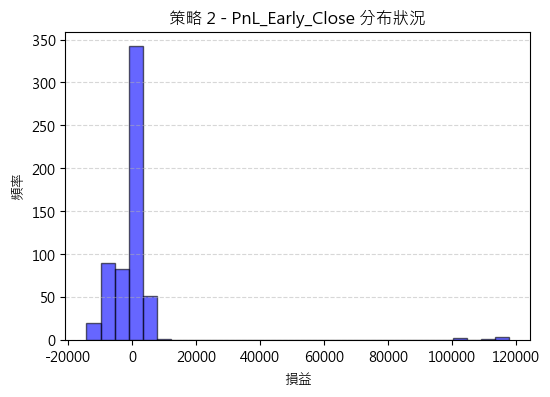

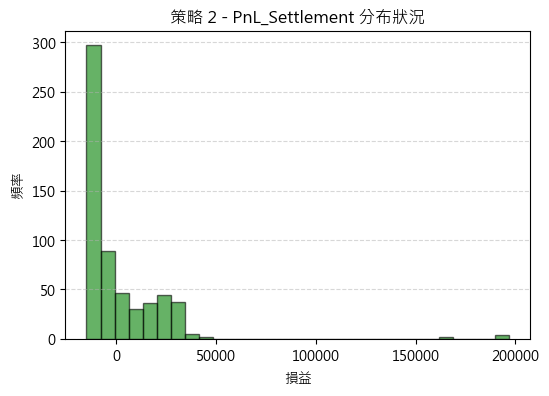

In [12]:
def plot_pnl_distribution(df_list, strategy_names):
    """ÂàÜÂà•Áπ™Ë£Ω PnL_Early_Close Âíå PnL_Settlement ÁöÑÁõ¥ÊñπÂúñ"""
    
    for df, strategy in zip(df_list, strategy_names):
        # **PnL_Early_Close Áõ¥ÊñπÂúñ**
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.hist(df["PnL_Early_Close"], bins=30, alpha=0.6, color="blue", edgecolor="black")
        ax.set_title(f"{strategy} - PnL_Early_Close ÂàÜÂ∏ÉÁãÄÊ≥Å", fontsize=12)
        ax.set_xlabel("ÊêçÁõä", fontsize=10)
        ax.set_ylabel("È†ªÁéá", fontsize=10)
        ax.grid(axis="y", linestyle="--", alpha=0.5)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))  # Á¢∫‰øùË≤†Êï∏Ê≠£Â∏∏È°ØÁ§∫
        plt.show()

        # **PnL_Settlement Áõ¥ÊñπÂúñ**
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.hist(df["PnL_Settlement"], bins=30, alpha=0.6, color="green", edgecolor="black")
        ax.set_title(f"{strategy} - PnL_Settlement ÂàÜÂ∏ÉÁãÄÊ≥Å", fontsize=12)
        ax.set_xlabel("ÊêçÁõä", fontsize=10)
        ax.set_ylabel("È†ªÁéá", fontsize=10)
        ax.grid(axis="y", linestyle="--", alpha=0.5)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))  # Á¢∫‰øùË≤†Êï∏Ê≠£Â∏∏È°ØÁ§∫
        plt.show()

plot_pnl_distribution(df_list, strategy_names)

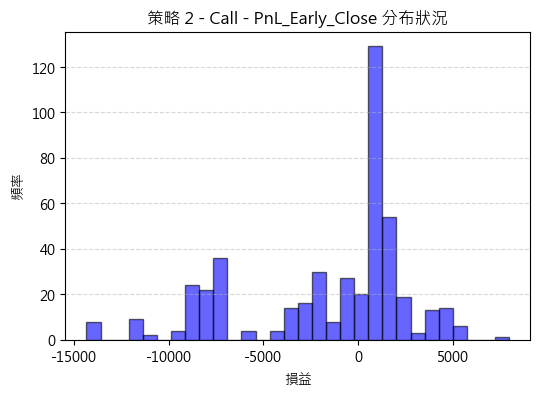

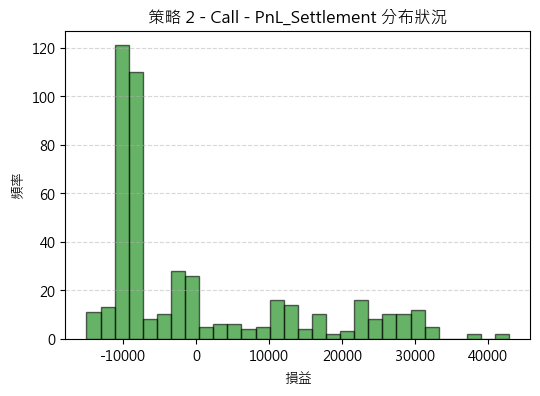

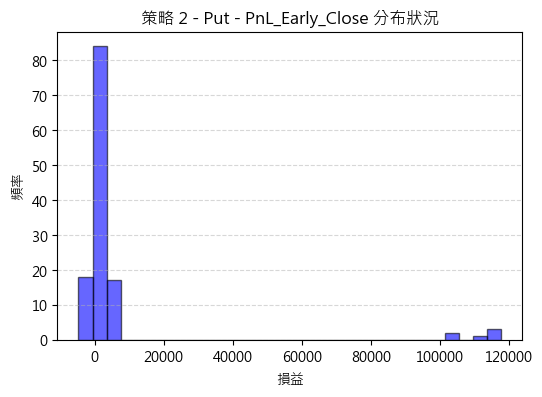

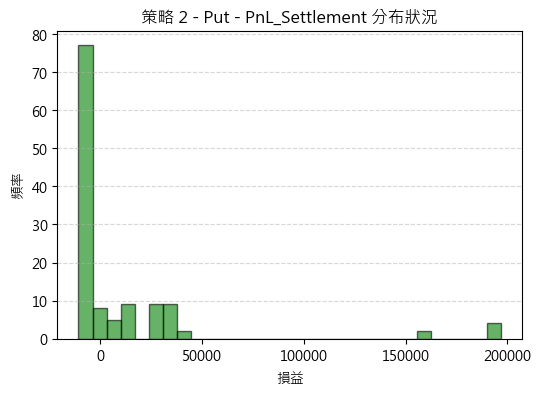

In [13]:
plot_pnl_distribution(df_list_o, strategy_names_o)

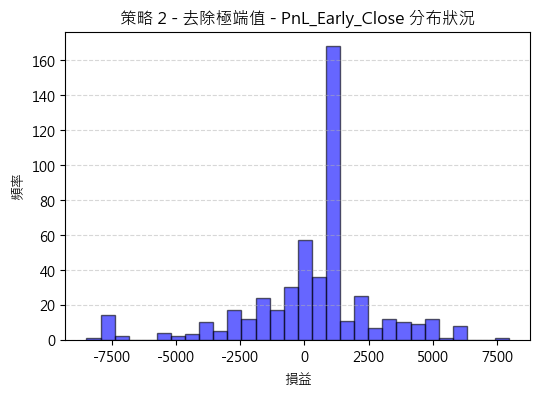

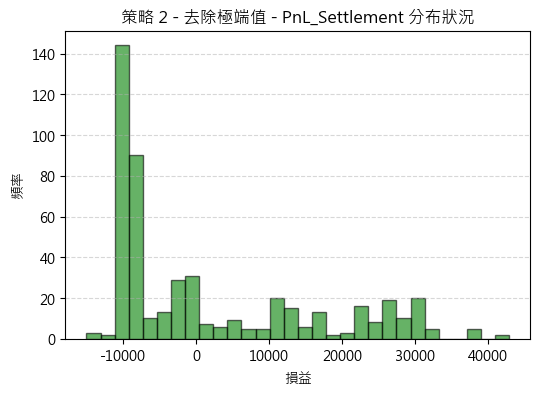

In [14]:
strategy_names_2 = ["Á≠ñÁï• 2 - ÂéªÈô§Ê•µÁ´ØÂÄº"]
plot_pnl_distribution(df_list_2, strategy_names_2)

ÂéªÈô§Ê•µÁ´ØÂÄºÂæåÂÅöËßÄÂØü

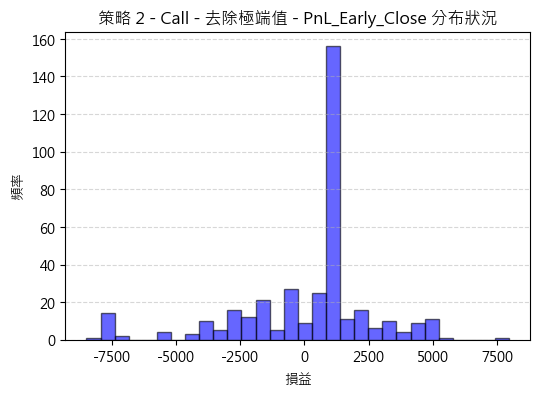

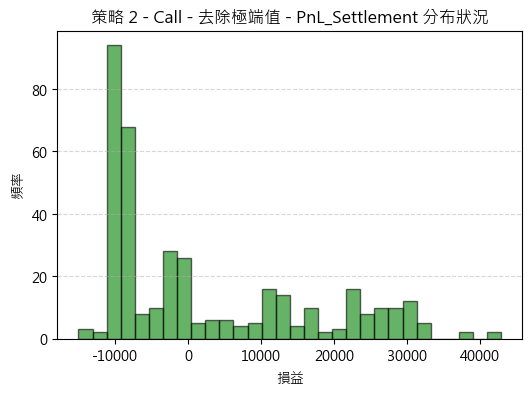

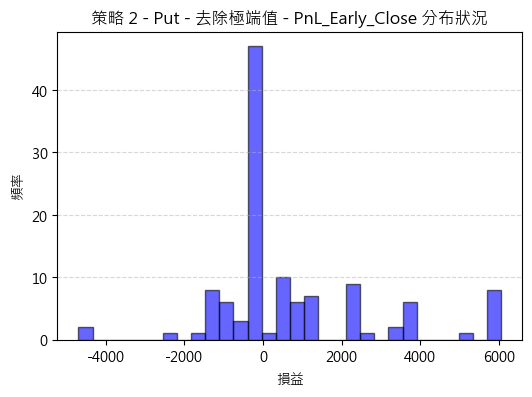

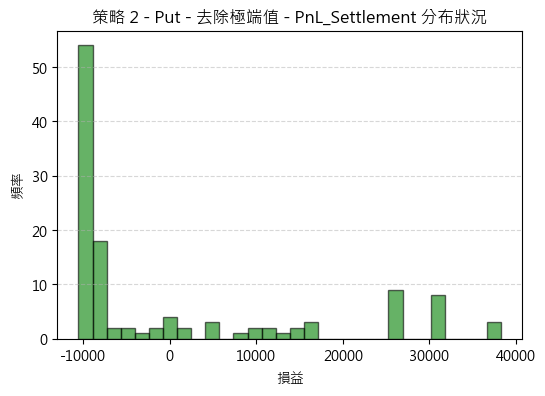

In [15]:
strategy_names_o_2 = ["Á≠ñÁï• 2 - Call - ÂéªÈô§Ê•µÁ´ØÂÄº", "Á≠ñÁï• 2 - Put - ÂéªÈô§Ê•µÁ´ØÂÄº"]
plot_pnl_distribution(df_list_o_2, strategy_names_o_2)

#### ÈÄêÊó•Á∏æÊïàÁ¥ØÁ©çËßÄÂØü

ÈöîÊó•Âπ≥ÂÄâ

c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


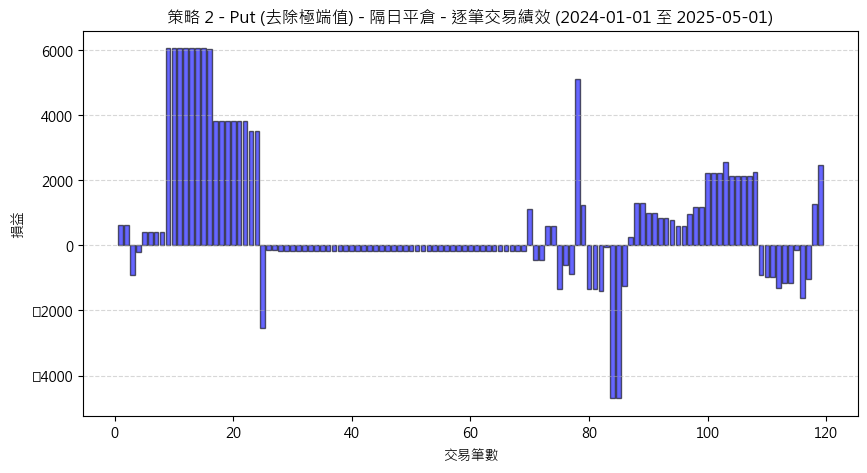

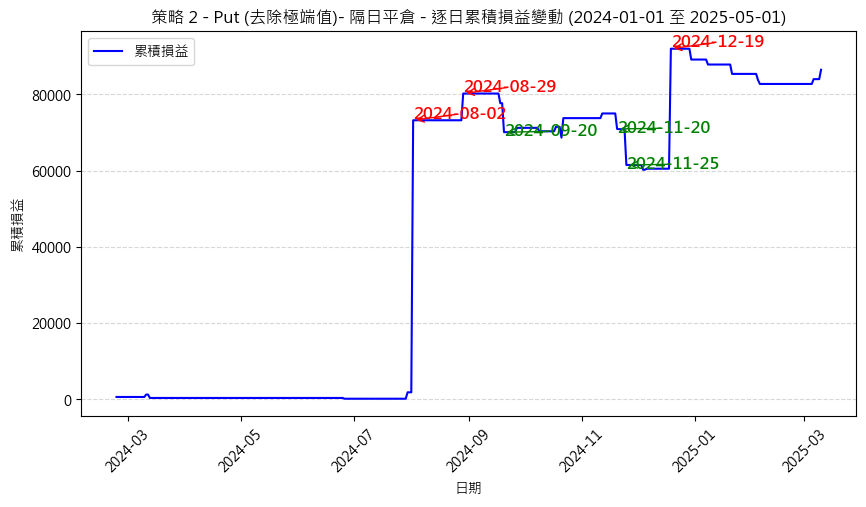

In [27]:
def format_date_range(start_date, end_date):
    """Ê†ºÂºèÂåñÊôÇÈñìÁØÑÂúçÁÇ∫ YYYY-MM-DD"""
    return f"{start_date.strftime('%Y-%m-%d')} Ëá≥ {end_date.strftime('%Y-%m-%d')}" if start_date and end_date else ""

def plot_trade_performance(df, strategy_name, start_date=None, end_date=None):
    """Áπ™Ë£ΩÈÄêÁ≠ÜÁ∏æÊïàË°®ÁèæÔºàÈï∑Ê¢ùÂúñÔºâÔºåÂèØÈÅ∏ÊìáÊôÇÈñìÁØÑÂúç"""
    
    df = df.copy()
    df.loc[:, "NewDate"] = pd.to_datetime(df["NewDate"])  # **Á¢∫‰øùÊó•ÊúüÊ†ºÂºèÊ≠£Á¢∫**
    
    # **ÁØ©ÈÅ∏ÊôÇÈñìÁØÑÂúç**
    if start_date and end_date:
        start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
        df = df[(df["NewDate"] >= start_date) & (df["NewDate"] <= end_date)]
    
    df["Trade_Index"] = range(1, len(df) + 1)  # **ÁÇ∫ÊØèÁ≠Ü‰∫§ÊòìÂª∫Á´ãÁ¥¢Âºï**
    
    plt.figure(figsize=(10, 5))
    plt.bar(df["Trade_Index"], df["PnL_Early_Close"], color="blue", alpha=0.6, edgecolor="black")
    date_range_str = format_date_range(start_date, end_date)
    plt.title(f"{strategy_name} - ÈöîÊó•Âπ≥ÂÄâ - ÈÄêÁ≠Ü‰∫§ÊòìÁ∏æÊïà ({date_range_str})")
    plt.xlabel("‰∫§ÊòìÁ≠ÜÊï∏")
    plt.ylabel("ÊêçÁõä")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

def plot_daily_cumulative_pnl(df, strategy_name, start_date=None, end_date=None):
    """Áπ™Ë£ΩÈÄêÊó•Á¥ØÁ©çÊêçÁõäËµ∞Âã¢ÔºåÂèØÈÅ∏ÊìáÊôÇÈñìÁØÑÂúç"""
    
    df = df.copy()
    df.loc[:, "NewDate"] = pd.to_datetime(df["NewDate"])  # **Á¢∫‰øùÊó•ÊúüÁÇ∫ datetime**
    
    # **ÁØ©ÈÅ∏ÊôÇÈñìÁØÑÂúç**
    if start_date and end_date:
        start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
        df = df[(df["NewDate"] >= start_date) & (df["NewDate"] <= end_date)]
    
    # **Â∞áÂêå‰∏ÄÂ§©ÁöÑÊï∏ÊìöÂä†Á∏Ω**
    df_daily = df.groupby("NewDate", as_index=False)["PnL_Early_Close"].sum()
    
    # **Â°´Ë£úÁº∫Â§±Êó•ÊúüÔºàË¶ñÁÇ∫ÊêçÁõäÊåÅÂπ≥Ôºâ**
    full_dates = pd.date_range(start=df_daily["NewDate"].min(), end=df_daily["NewDate"].max(), freq="D")
    df_daily = df_daily.set_index("NewDate").reindex(full_dates, fill_value=0).reset_index()
    df_daily.rename(columns={"index": "NewDate"}, inplace=True)
    
    # **Ë®àÁÆóÁ¥ØÁ©çÊêçÁõä**
    df_daily["Cumulative_PnL"] = df_daily["PnL_Early_Close"].cumsum()

    # **Ë≠òÂà•Áï∞Â∏∏ËÆäÂãïÈªû**
    df_daily["PnL_Change"] = df_daily["Cumulative_PnL"].diff()
    # **Á¢∫‰øù 'PnL_Change' Ê¨Ñ‰ΩçÊòØ float ÂûãÊÖã**
    df_daily["PnL_Change"] = pd.to_numeric(df_daily["PnL_Change"], errors="coerce")

    # **ÂéªÈô§ NaN ÂÄº**
    df_daily = df_daily.dropna(subset=["PnL_Change"])
    highlight_dates_1 = df_daily.nlargest(3, "PnL_Change")["NewDate"]  # **ÊâæÂá∫ËÆäÂãïÊúÄÂ§ßÁöÑ3Â§©**
    highlight_dates_2 = df_daily.nsmallest(3, "PnL_Change")["NewDate"]  # **ÊâæÂá∫ËÆäÂãïÊúÄÂ∞èÁöÑ3Â§©**

    # **Áπ™Ë£ΩÁ¥ØÁ©çÊêçÁõäÊäòÁ∑öÂúñ**
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_daily["NewDate"], df_daily["Cumulative_PnL"], color="blue", linestyle="-", label="Á¥ØÁ©çÊêçÁõä")

    # **Ê®ôË®ªÁï∞Â∏∏Ê≥¢ÂãïÈªûÔºàÂêë‰∏äÁßªÂãïÔºåÊ®ôË®ªÊñáÂ≠óÊîπÁÇ∫Á¥ÖËâ≤Ôºâ**
    for date in highlight_dates_1:
        pnl_value = df_daily.loc[df_daily["NewDate"] == date, "Cumulative_PnL"].values[0]
        ax.annotate(f"{date.strftime('%Y-%m-%d')}", 
                    xy=(date, pnl_value), xytext=(date, pnl_value + 500),  # **Âêë‰∏äË™øÊï¥Ê®ôË®ª‰ΩçÁΩÆ**
                    arrowprops=dict(arrowstyle="->", color="red"),
                    color="red", fontsize=12, fontweight="bold")  # **Ê®ôË®ªÊó•ÊúüÁÇ∫Á¥ÖËâ≤**
    
    for date in highlight_dates_2:
        pnl_value = df_daily.loc[df_daily["NewDate"] == date, "Cumulative_PnL"].values[0]
        ax.annotate(f"{date.strftime('%Y-%m-%d')}", 
                    xy=(date, pnl_value), xytext=(date, pnl_value - 1000),  # **Âêë‰∏äË™øÊï¥Ê®ôË®ª‰ΩçÁΩÆ**
                    arrowprops=dict(arrowstyle="->", color="green"),
                    color="green", fontsize=12, fontweight="bold")  # **Ê®ôË®ªÊó•ÊúüÁÇ∫Á¥ÖËâ≤**


    date_range_str = format_date_range(start_date, end_date)
    ax.set_title(f"{strategy_name}- ÈöîÊó•Âπ≥ÂÄâ - ÈÄêÊó•Á¥ØÁ©çÊêçÁõäËÆäÂãï ({date_range_str})")
    ax.set_xlabel("Êó•Êúü")
    ax.set_ylabel("Á¥ØÁ©çÊêçÁõä")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.xticks(rotation=45)
    plt.show()


# df_new_2
# df_clean
# df_new_2_call, df_new_2_put
# df_clean_2_call, df_clean_2_put


plot_trade_performance(df_clean_2_put, "Á≠ñÁï• 2 - Put (ÂéªÈô§Ê•µÁ´ØÂÄº)", start_date="2024-01-01", end_date="2025-05-01")
plot_daily_cumulative_pnl(df_clean_2_put, "Á≠ñÁï• 2 - Put (ÂéªÈô§Ê•µÁ´ØÂÄº)", start_date="2024-01-01", end_date="2025-05-01")

c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


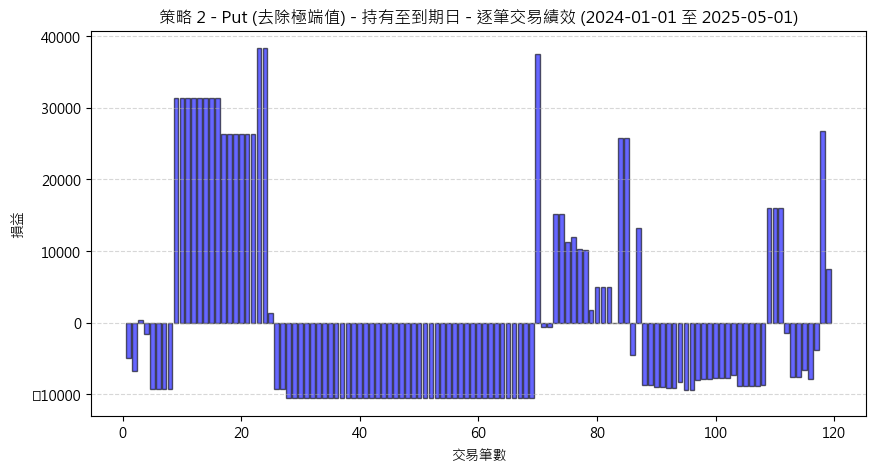

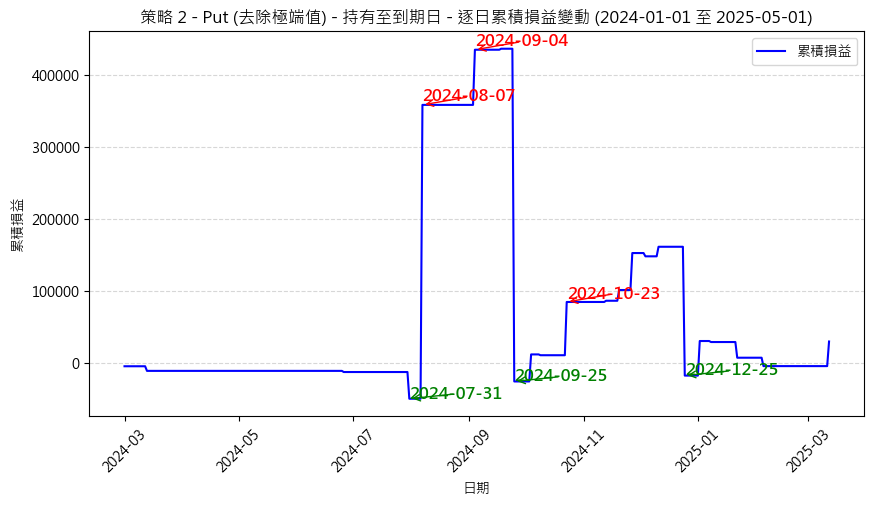

In [29]:
def format_date_range(start_date, end_date):
    """Ê†ºÂºèÂåñÊôÇÈñìÁØÑÂúçÁÇ∫ YYYY-MM-DD"""
    return f"{start_date.strftime('%Y-%m-%d')} Ëá≥ {end_date.strftime('%Y-%m-%d')}" if start_date and end_date else ""

def plot_trade_performance_settlement(df, strategy_name, start_date=None, end_date=None):
    """Áπ™Ë£ΩÈÄêÁ≠Ü‰∫§ÊòìÁ∏æÊïàÔºàÈï∑Ê¢ùÂúñÔºâÔºåÊ®ôÈ°åÈ°ØÁ§∫Á∞°ÂåñÊôÇÈñìÊ†ºÂºè"""
    
    df = df.copy()
    df.loc[:, "SettlementDate"] = pd.to_datetime(df["SettlementDate"])  # **Á¢∫‰øùÊó•ÊúüÊ†ºÂºèÊ≠£Á¢∫**
    
    # **ÁØ©ÈÅ∏ÊôÇÈñìÁØÑÂúç**
    if start_date and end_date:
        start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
        df = df[(df["SettlementDate"] >= start_date) & (df["SettlementDate"] <= end_date)]
    
    df["Trade_Index"] = range(1, len(df) + 1)  # **ÁÇ∫ÊØèÁ≠Ü‰∫§ÊòìÂª∫Á´ãÁ¥¢Âºï**
    
    plt.figure(figsize=(10, 5))
    plt.bar(df["Trade_Index"], df["PnL_Settlement"], color="blue", alpha=0.6, edgecolor="black")
    
    # **Á∞°ÂåñÊôÇÈñìÁØÑÂúç**
    date_range_str = format_date_range(start_date, end_date)
    plt.title(f"{strategy_name} - ÊåÅÊúâËá≥Âà∞ÊúüÊó• - ÈÄêÁ≠Ü‰∫§ÊòìÁ∏æÊïà ({date_range_str})")
    
    plt.xlabel("‰∫§ÊòìÁ≠ÜÊï∏")
    plt.ylabel("ÊêçÁõä")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

def plot_daily_cumulative_pnl_settlement(df, strategy_name, start_date=None, end_date=None):
    """Áπ™Ë£ΩÈÄêÊó•Á¥ØÁ©çÊêçÁõäËµ∞Âã¢ÔºåÊ®ôÈ°åÈ°ØÁ§∫Á∞°ÂåñÊôÇÈñìÊ†ºÂºè"""
    
    df = df.copy()
    df.loc[:, "SettlementDate"] = pd.to_datetime(df["SettlementDate"])  # **Á¢∫‰øùÊó•ÊúüÊ†ºÂºèÊ≠£Á¢∫**

    # **ÁØ©ÈÅ∏ÊôÇÈñìÁØÑÂúç**
    if start_date and end_date:
        start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
        df = df[(df["SettlementDate"] >= start_date) & (df["SettlementDate"] <= end_date)]
    
    # **Â∞áÂêå‰∏ÄÂ§©ÁöÑÊï∏ÊìöÂä†Á∏Ω**
    df_daily = df.groupby("SettlementDate", as_index=False)["PnL_Settlement"].sum()

    # **Â°´Ë£úÁº∫Â§±Êó•ÊúüÔºàË¶ñÁÇ∫ÊêçÁõäÊåÅÂπ≥Ôºâ**
    full_dates = pd.date_range(start=df_daily["SettlementDate"].min(), end=df_daily["SettlementDate"].max(), freq="D")
    df_daily = df_daily.set_index("SettlementDate").reindex(full_dates, fill_value=0).reset_index()
    df_daily.rename(columns={"index": "SettlementDate"}, inplace=True)

    # **Ë®àÁÆóÁ¥ØÁ©çÊêçÁõä**
    df_daily["Cumulative_PnL"] = df_daily["PnL_Settlement"].cumsum()

    # **Ë≠òÂà•Áï∞Â∏∏ËÆäÂãïÈªû**
    df_daily["PnL_Change"] = df_daily["Cumulative_PnL"].diff()
    # **Á¢∫‰øù 'PnL_Change' Ê¨Ñ‰ΩçÊòØ float ÂûãÊÖã**
    df_daily["PnL_Change"] = pd.to_numeric(df_daily["PnL_Change"], errors="coerce")

    # **ÂéªÈô§ NaN ÂÄº**
    df_daily = df_daily.dropna(subset=["PnL_Change"])
    highlight_dates_1 = df_daily.nlargest(3, "PnL_Change")["SettlementDate"]  # **ÊâæÂá∫ËÆäÂãïÊúÄÂ§ßÁöÑ3Â§©**
    highlight_dates_2 = df_daily.nsmallest(3, "PnL_Change")["SettlementDate"]  # **ÊâæÂá∫ËÆäÂãïÊúÄÂ§ßÁöÑ3Â§©**

    # **Áπ™Ë£ΩÁ¥ØÁ©çÊêçÁõäÊäòÁ∑öÂúñ**
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_daily["SettlementDate"], df_daily["Cumulative_PnL"], color="blue", linestyle="-", label="Á¥ØÁ©çÊêçÁõä")

    # **Á∞°ÂåñÊôÇÈñìÊ®ôÈ°å**
    date_range_str = format_date_range(start_date, end_date)
    # **Ê®ôË®ªÁï∞Â∏∏Ê≥¢ÂãïÈªûÔºàÂêë‰∏äÁßªÂãïÔºåÊ®ôË®ªÊñáÂ≠óÊîπÁÇ∫Á¥ÖËâ≤Ôºâ**
    for date in highlight_dates_1:
        pnl_value = df_daily.loc[df_daily["SettlementDate"] == date, "Cumulative_PnL"].values[0]
        ax.annotate(f"{date.strftime('%Y-%m-%d')}", 
                    xy=(date, pnl_value), xytext=(date, pnl_value + 5000),  # **Âêë‰∏äË™øÊï¥Ê®ôË®ª‰ΩçÁΩÆ**
                    arrowprops=dict(arrowstyle="->", color="red"),
                    color="red", fontsize=12, fontweight="bold")  # **Ê®ôË®ªÊó•ÊúüÁÇ∫Á¥ÖËâ≤*

    for date in highlight_dates_2:
        pnl_value = df_daily.loc[df_daily["SettlementDate"] == date, "Cumulative_PnL"].values[0]
        ax.annotate(f"{date.strftime('%Y-%m-%d')}", 
                    xy=(date, pnl_value), xytext=(date, pnl_value + 500),  # **Âêë‰∏äË™øÊï¥Ê®ôË®ª‰ΩçÁΩÆ**
                    arrowprops=dict(arrowstyle="->", color="green"),
                    color="green", fontsize=12, fontweight="bold")  # **Ê®ôË®ªÊó•ÊúüÁÇ∫Á¥ÖËâ≤**


    ax.set_title(f"{strategy_name} - ÊåÅÊúâËá≥Âà∞ÊúüÊó• - ÈÄêÊó•Á¥ØÁ©çÊêçÁõäËÆäÂãï ({date_range_str})")
    ax.set_xlabel("Êó•Êúü")
    ax.set_ylabel("Á¥ØÁ©çÊêçÁõä")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.xticks(rotation=45)
    plt.show()

# df_new_2
# df_clean
# df_new_2_call, df_new_2_put
# df_clean_2_call, df_clean_2_put


plot_trade_performance_settlement(df_clean_2_put, "Á≠ñÁï• 2 - Put (ÂéªÈô§Ê•µÁ´ØÂÄº)", start_date="2024-01-01", end_date="2025-05-01")
plot_daily_cumulative_pnl_settlement(df_clean_2_put, "Á≠ñÁï• 2 - Put (ÂéªÈô§Ê•µÁ´ØÂÄº)", start_date="2024-01-01", end_date="2025-05-01")

#### ÈÄêÊúàÁ∏æÊïàÁ¥ØÁ©çËßÄÂØü

C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_4500\1642613273.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["NewDate"] = pd.to_datetime(df["NewDate"], errors="coerce")
C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_4500\1642613273.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=["NewDate"], inplace=True)
C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_4500\1642613273.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

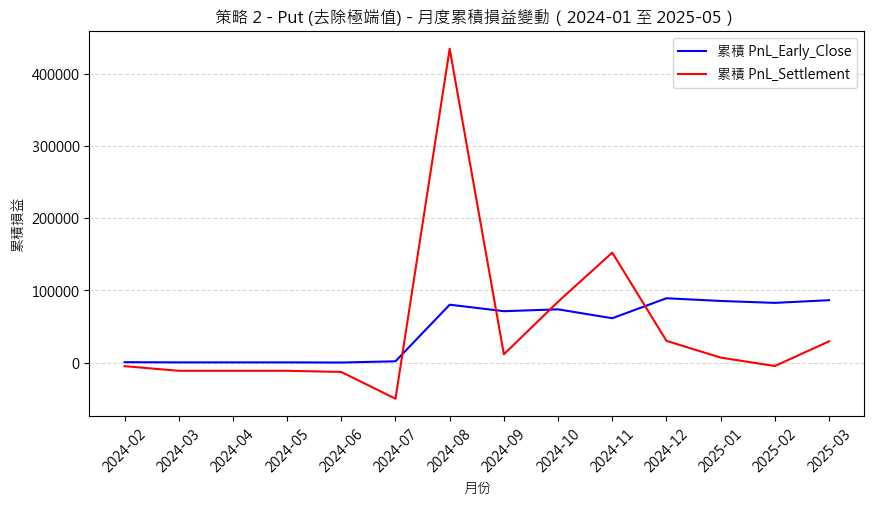

In [30]:
def plot_monthly_cumulative_pnl(df_early, df_settle, strategy_name, start_date=None, end_date=None):
    """ÂàÜÂà•Áπ™Ë£ΩÊúàÂ∫¶Á¥ØÁ©çÊêçÁõäËµ∞Âã¢ÔºåÈÅ©Áî®Êñº‰∏çÂêåÁöÑ Early Close Âíå Settlement Êï∏Êìö"""

    # **Á¢∫‰øù 'NewDate' ÁÇ∫ datetime Ê†ºÂºè**
    for df in [df_early, df_settle]:
        df["NewDate"] = pd.to_datetime(df["NewDate"], errors="coerce")
        df.dropna(subset=["NewDate"], inplace=True)
        assert df["NewDate"].dtype == "datetime64[ns]", "üö® NewDate Ê¨Ñ‰Ωç‰ªç‰∏çÊòØ datetime Ê†ºÂºèÔºÅË´ãÊ™¢Êü•ÂéüÂßãË≥áÊñô„ÄÇ"
        df["Month"] = df["NewDate"].dt.to_period("M")  # **ËΩâÊèõÁÇ∫Êúà‰ªΩ**

    # **ÁØ©ÈÅ∏ÊôÇÈñìÁØÑÂúç**
    if start_date and end_date:
        start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
        df_early = df_early[(df_early["NewDate"] >= start_date) & (df_early["NewDate"] <= end_date)]
        df_settle = df_settle[(df_settle["NewDate"] >= start_date) & (df_settle["NewDate"] <= end_date)]

    # **Ë®àÁÆóÊØèÊúàÊêçÁõä**
    df_monthly_early = df_early.groupby("Month", as_index=False)["PnL_Early_Close"].sum()
    df_monthly_settle = df_settle.groupby("Month", as_index=False)["PnL_Settlement"].sum()

    # **Â°´Ë£úÁº∫Â§±Êúà‰ªΩ**
    full_months = pd.period_range(start=df_monthly_early["Month"].min(), end=df_monthly_early["Month"].max(), freq="M")
    df_monthly_early = df_monthly_early.set_index("Month").reindex(full_months, fill_value=0).reset_index()
    df_monthly_settle = df_monthly_settle.set_index("Month").reindex(full_months, fill_value=0).reset_index()

    df_monthly_early.rename(columns={"index": "Month"}, inplace=True)
    df_monthly_settle.rename(columns={"index": "Month"}, inplace=True)

    # **Ë®àÁÆóÁ¥ØÁ©çÊêçÁõä**
    df_monthly_early["Cumulative_PnL_Early_Close"] = df_monthly_early["PnL_Early_Close"].cumsum()
    df_monthly_settle["Cumulative_PnL_Settlement"] = df_monthly_settle["PnL_Settlement"].cumsum()

    # **Áπ™Ë£ΩÁ¥ØÁ©çÊêçÁõäÊäòÁ∑öÂúñ**
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_monthly_early["Month"].astype(str), df_monthly_early["Cumulative_PnL_Early_Close"], color="blue", linestyle="-", label="Á¥ØÁ©ç PnL_Early_Close")
    ax.plot(df_monthly_settle["Month"].astype(str), df_monthly_settle["Cumulative_PnL_Settlement"], color="red", linestyle="-", label="Á¥ØÁ©ç PnL_Settlement")

    ax.set_title(f"{strategy_name} - ÊúàÂ∫¶Á¥ØÁ©çÊêçÁõäËÆäÂãïÔºà{start_date.strftime('%Y-%m')} Ëá≥ {end_date.strftime('%Y-%m')}Ôºâ" if start_date and end_date else f"{strategy_name} - ÊúàÂ∫¶Á¥ØÁ©çÊêçÁõäËÆäÂãï")
    ax.set_xlabel("Êúà‰ªΩ")
    ax.set_ylabel("Á¥ØÁ©çÊêçÁõä")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.xticks(rotation=45)
    plt.show()

# df_new_2
# df_clean
# df_new_2_call, df_new_2_put
# df_clean_2_call, df_clean_2_put

# **Ê∏¨Ë©¶ÂáΩÊï∏**
plot_monthly_cumulative_pnl(df_clean_2_put,  df_clean_2_put, "Á≠ñÁï• 2 - Put (ÂéªÈô§Ê•µÁ´ØÂÄº)", start_date="2024-01-01", end_date="2025-05-01")

#### Áπ™Ë£ΩDeltaËÆäÂåñÂúñ

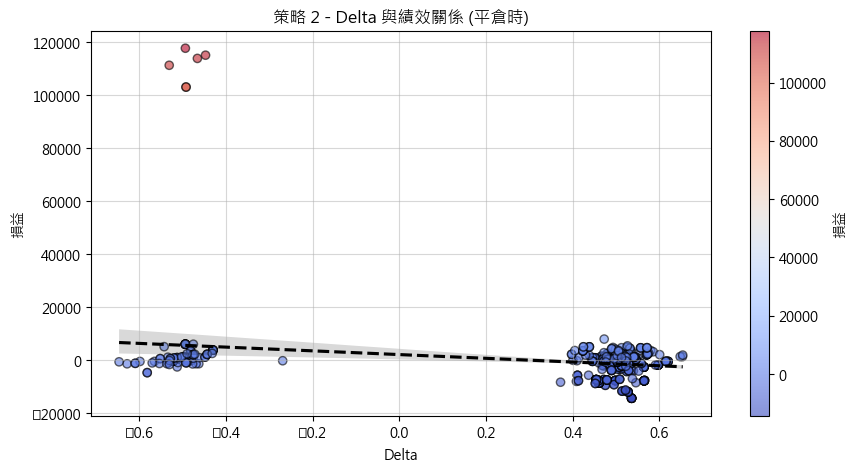

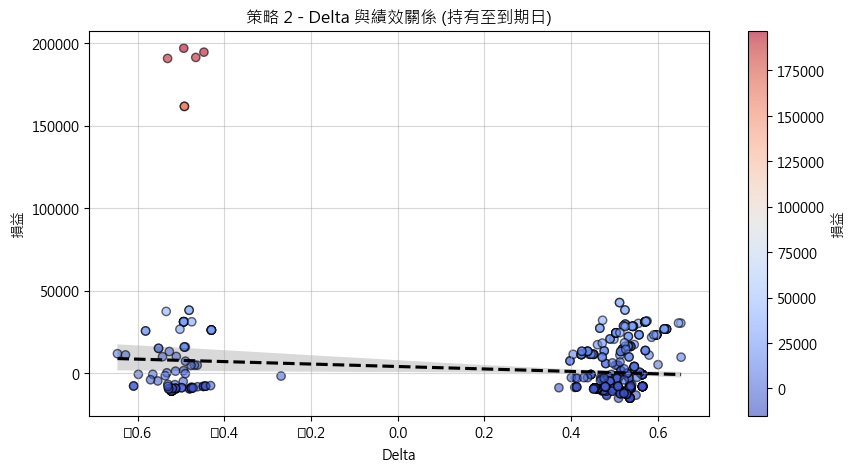

In [52]:
def plot_delta_vs_pnl(df, strategy_name, use_settlement=False):
    """Áπ™Ë£Ω Delta ËàáÊêçÁõäÁöÑÈóú‰øÇÔºàÊï£ÈªûÂúñÔºâ"""

    df = df.copy()
    df["Delta"] = pd.to_numeric(df["Delta"], errors="coerce")  # **Á¢∫‰øù Delta ÁÇ∫Êï∏ÂÄº**
    
    # **ÈÅ∏Êìá PnL**
    pnl_col = "PnL_Settlement" if use_settlement else "PnL_Early_Close"
    df[pnl_col] = pd.to_numeric(df[pnl_col], errors="coerce")  # **Á¢∫‰øù PnL ÁÇ∫Êï∏ÂÄº**
    
    # **ÁßªÈô§ NaN ÂÄº**
    df = df.dropna(subset=["Delta", pnl_col])
    
    # **Áπ™Ë£ΩÊï£ÈªûÂúñ**
    plt.figure(figsize=(10, 5))
    scatter = plt.scatter(df["Delta"], df[pnl_col], c=df[pnl_col], cmap="coolwarm", alpha=0.6, edgecolors="black")

    # **Âä†ÂÖ•È°èËâ≤Ê¢ù**
    cbar = plt.colorbar(scatter)
    cbar.set_label("ÊêçÁõä")

    # **Ë∂®Âã¢Á∑ö**
    sns.regplot(x=df["Delta"], y=df[pnl_col], scatter=False, line_kws={"color": "black", "linestyle": "--"})

    plt.title(f"{strategy_name} - Delta ËàáÁ∏æÊïàÈóú‰øÇ ({'ÊåÅÊúâËá≥Âà∞ÊúüÊó•' if use_settlement else 'Âπ≥ÂÄâÊôÇ'})")
    plt.xlabel("Delta")
    plt.ylabel("ÊêçÁõä")
    plt.grid(alpha=0.5)
    plt.show()

plot_delta_vs_pnl(df_new_2, "Á≠ñÁï• 2", use_settlement=False)  # **‰ΩøÁî®Âπ≥ÂÄâ PnL**
plot_delta_vs_pnl(df_new_2, "Á≠ñÁï• 2", use_settlement=True)  # **‰ΩøÁî®ÊåÅÊúâËá≥Âà∞ÊúüÊó• PnL**

Ë®àÁÆóÈÄêÊó•DeltaÁ¥ØÁ©ç

ÈöîÊó•Âπ≥ÂÄâÁ≠ñÁï•ÔºöÊØèÂ§©ÈÉΩÊòØÂÖ®Êñ∞ÁöÑ‰∏ÄÂ§©

ÊåÅÊúâÂà∞Âà∞ÊúüÊó•Á≠ñÁï•ÔºöÁ¥ØÁ©çÂà∞Âà∞ÊúüÊó•Ââç (ËßÄÂØüÁ¥ØÁ©ç‰πãDeltaÂ§ßÂ∞è)

C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_17016\2311845034.py:75: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


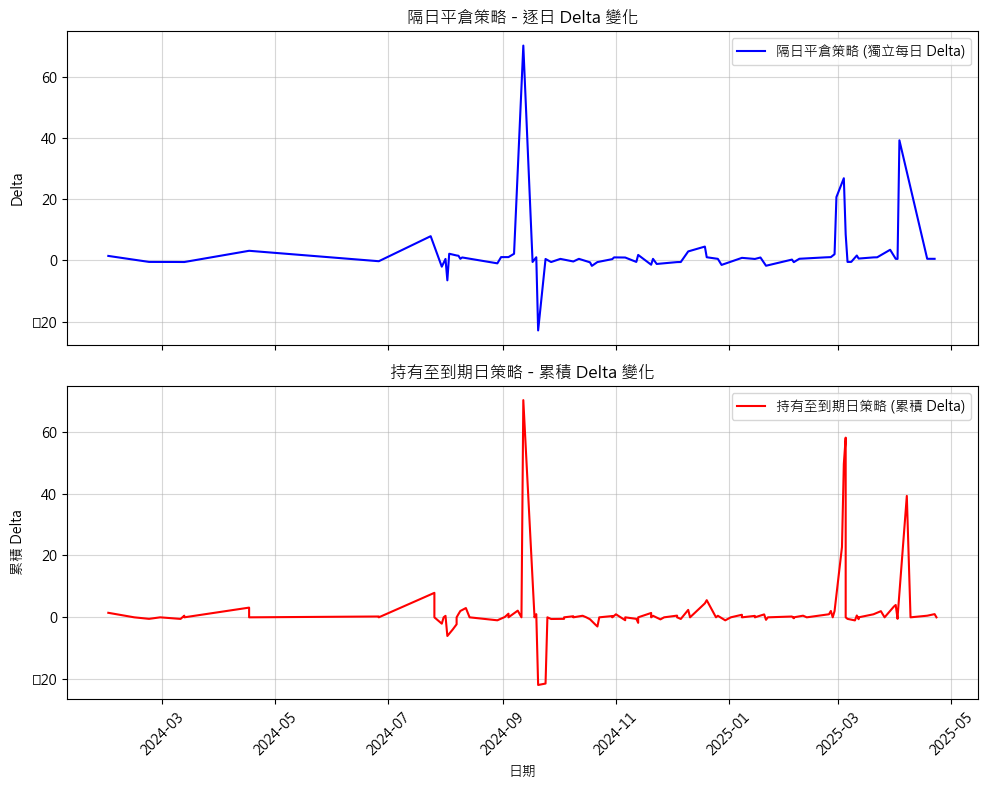

In [53]:
def prepare_delta_data(df):
    """Ê∫ñÂÇô Delta Êï∏ÊìöÔºåÁ¢∫‰øùÂÖ∂ÁÇ∫Êï∏ÂÄºÂûãÊÖã"""
    
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"])  # **Á¢∫‰øù Date ÁÇ∫ datetime**
    df["SettlementDate"] = pd.to_datetime(df["SettlementDate"])  # **Á¢∫‰øù SettlementDate ÁÇ∫ datetime**
    df["NewDate"] = pd.to_datetime(df["NewDate"])

    # **Á¢∫‰øù Delta ÊòØÊï∏ÂÄºÂûãÊÖã**
    df["Delta"] = pd.to_numeric(df["Delta"], errors="coerce")

    # **ÁßªÈô§ NaNÔºåÈÅøÂÖçÂΩ±ÈüøË®àÁÆó**
    df = df.dropna(subset=["Date", "SettlementDate", "NewDate", "Delta"])

    return df

def calculate_daily_delta(df):
    """ÈöîÊó•Âπ≥ÂÄâÁ≠ñÁï•ÔºöÊØèÂ§©ÁöÑ Delta ‰∏çÁ¥ØÁ©çÔºåÂÉÖË®àÁÆóÁï∂Â§©ÂÄº"""
    df_daily = df.groupby("Date", as_index=False)["Delta"].sum()
    df_daily.rename(columns={"Delta": "Daily_Delta"}, inplace=True)
    return df_daily

def calculate_cumulative_delta(df):
    """ÊåÅÊúâËá≥Âà∞ÊúüÊó•Á≠ñÁï•ÔºöÊØèÊó• Delta Á¥ØÁ©çÔºå‰∏¶Âú® SettlementDate Âà∞ÊúüÊôÇÊâ£Èô§Áõ∏ÊáâÊï∏Êìö"""
    
    # **Á¢∫‰øùÊï∏ÊìöÊ†ºÂºè**
    df = df.copy()
    df["NewDate"] = pd.to_datetime(df["NewDate"])  # **ËΩâÊèõ NewDate ÁÇ∫ datetime**
    df["SettlementDate"] = pd.to_datetime(df["SettlementDate"])  # **ËΩâÊèõ SettlementDate ÁÇ∫ datetime**
    df["Delta"] = pd.to_numeric(df["Delta"], errors="coerce")  # **Á¢∫‰øù Delta ÁÇ∫Êï∏ÂÄºÂûãÊÖã**
    
    # **ÁßªÈô§ NaNÔºåÈÅøÂÖçÈåØË™§Ë®àÁÆó**
    df = df.dropna(subset=["NewDate", "SettlementDate", "Delta"])
    
    # **Ë®àÁÆóÊØèÊó• DeltaÔºàÁ¥ØÁ©çÔºâ**
    df_daily = df.groupby("NewDate", as_index=False)["Delta"].sum()
    df_daily["Cumulative_Delta"] = df_daily["Delta"].cumsum()

    # **ËôïÁêÜ SettlementDate Âà∞ÊúüÊôÇÁöÑÊâ£Èô§**
    df_settlement = df.groupby("SettlementDate", as_index=False)["Delta"].sum()
    df_settlement["NewDate"] = df_settlement["SettlementDate"]  # **Â∞áÂà∞ÊúüÊó•Êò†Â∞ÑÁÇ∫Ë¶ÅÊâ£Èô§ÁöÑÊó•Êúü**
    df_settlement["Delta"] = -df_settlement["Delta"]  # **ËΩâÁÇ∫Ë≤†Êï∏ÔºàË°®Á§∫Êâ£Èô§Ôºâ**

    # **Âêà‰ΩµÊØèÊó•Á¥ØÁ©çÊï∏Êìö & Âà∞ÊúüÊó•Êâ£Èô§Êï∏Êìö**
    df_combined = pd.concat([df_daily, df_settlement], ignore_index=True).sort_values("NewDate")
    df_combined["Cumulative_Delta_Adjusted"] = df_combined["Delta"].cumsum()
    df_combined["Cumulative_Delta"] = df_combined["Cumulative_Delta"].fillna(0)

    # **Á¢∫‰øùËº∏Âá∫Êó•ÊúüÊ¨Ñ‰ΩçÂêçÁ®±‰∏ÄËá¥**
    df_combined.rename(columns={"NewDate": "Date"}, inplace=True)

    return df_combined

def plot_delta_trends(df_daily, df_cumulative):
    """Áπ™Ë£Ω Delta Á¥ØÁ©çË∂®Âã¢ÊØîËºÉ"""

    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # **ÈöîÊó•Âπ≥ÂÄâÁ≠ñÁï•**
    ax[0].plot(df_daily["Date"], df_daily["Daily_Delta"], color="blue", linestyle="-", label="ÈöîÊó•Âπ≥ÂÄâÁ≠ñÁï• (Áç®Á´ãÊØèÊó• Delta)")
    ax[0].set_title("ÈöîÊó•Âπ≥ÂÄâÁ≠ñÁï• - ÈÄêÊó• Delta ËÆäÂåñ")
    ax[0].set_ylabel("Delta")
    ax[0].legend()
    ax[0].grid(alpha=0.5)

    # **ÊåÅÊúâËá≥Âà∞ÊúüÊó•Á≠ñÁï•**
    ax[1].plot(df_cumulative["Date"], df_cumulative["Cumulative_Delta_Adjusted"], color="red", linestyle="-", label="ÊåÅÊúâËá≥Âà∞ÊúüÊó•Á≠ñÁï• (Á¥ØÁ©ç Delta)")
    ax[1].set_title("ÊåÅÊúâËá≥Âà∞ÊúüÊó•Á≠ñÁï• - Á¥ØÁ©ç Delta ËÆäÂåñ")
    ax[1].set_xlabel("Êó•Êúü")
    ax[1].set_ylabel("Á¥ØÁ©ç Delta")
    ax[1].legend()
    ax[1].grid(alpha=0.5)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


df_clean = prepare_delta_data(df_new_2)
df_daily_delta = calculate_daily_delta(df_clean)
df_cumulative_delta = calculate_cumulative_delta(df_clean)
plot_delta_trends(df_daily_delta, df_cumulative_delta)

In [54]:
date_counts = df_new_2["Date"].value_counts().reset_index()
date_counts.columns = ["Date", "Count"]
date_counts = date_counts.sort_values(by="Count", ascending=False)  # **Áî±È´òÂà∞‰ΩéÊéíÂ∫è**

# **È°ØÁ§∫Ââç 10 Âêç**
print(date_counts.head(10))

         Date  Count
0  2024-09-12    136
1  2025-04-03     94
2  2024-12-19     49
3  2025-03-04     47
4  2024-09-20     44
5  2025-02-28     39
6  2025-03-05     18
7  2024-07-24     14
8  2024-08-02     14
9  2025-03-29      7


C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_17016\60845163.py:44: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


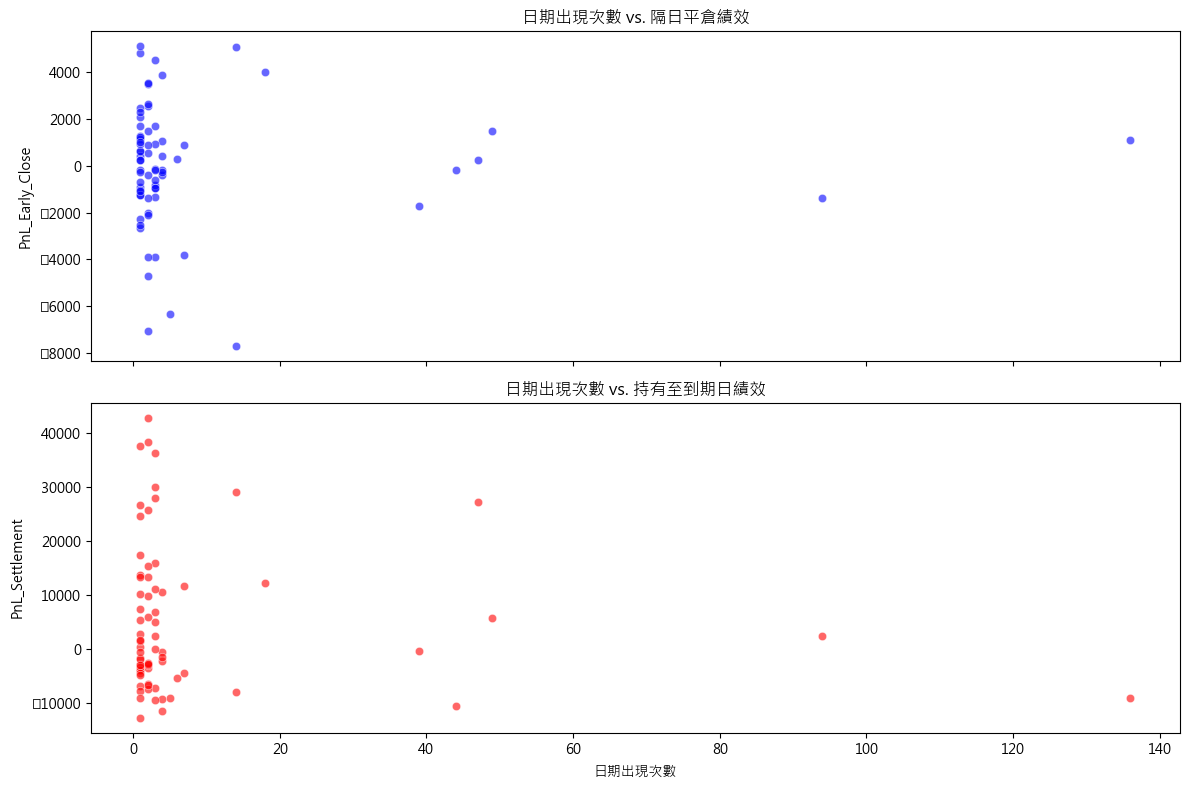

In [55]:
def analyze_date_performance(df):
    """ÂàÜÊûêÊó•ÊúüÂá∫ÁèæÊ¨°Êï∏ËàáÁ∏æÊïàÁöÑÈóú‰øÇ"""
    
    df = df.copy()
    
    # **Á¢∫‰øùÊï∏ÊìöÊ†ºÂºèÊ≠£Á¢∫**
    df["Date"] = pd.to_datetime(df["Date"])  # Á¢∫‰øù Date ÊòØ datetime
    df["SettlementDate"] = pd.to_datetime(df["SettlementDate"])
    df["PnL_Early_Close"] = pd.to_numeric(df["PnL_Early_Close"], errors="coerce")
    df["PnL_Settlement"] = pd.to_numeric(df["PnL_Settlement"], errors="coerce")
    
    # **Ë®àÁÆóÊó•ÊúüÂá∫ÁèæÊ¨°Êï∏**
    date_counts = df["Date"].value_counts().reset_index()
    date_counts.columns = ["Date", "Count"]
    
    # **ÊåâÊó•ÊúüË®àÁÆóÂπ≥ÂùáÁ∏æÊïà**
    df_performance = df.groupby("Date").agg({
        "PnL_Early_Close": "mean",
        "PnL_Settlement": "mean"
    }).reset_index()
    
    # **Âêà‰ΩµÊó•ÊúüÈ†ªÁéáËàáÁ∏æÊïàÊï∏Êìö**
    df_analysis = date_counts.merge(df_performance, on="Date", how="left")
    
    return df_analysis

def plot_date_vs_pnl(df_analysis):
    """Ë¶ñË¶∫ÂåñÊó•ÊúüÈ†ªÁéá vs. PnL Ë°®Áèæ"""
    
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # **Êï£ÈªûÂúñÔºöÊó•ÊúüÈ†ªÁéá vs. ÈöîÊó•Âπ≥ÂÄâÁ∏æÊïà**
    sns.scatterplot(x=df_analysis["Count"], y=df_analysis["PnL_Early_Close"], ax=ax[0], color="blue", alpha=0.6)
    ax[0].set_title("Êó•ÊúüÂá∫ÁèæÊ¨°Êï∏ vs. ÈöîÊó•Âπ≥ÂÄâÁ∏æÊïà")
    ax[0].set_xlabel("Êó•ÊúüÂá∫ÁèæÊ¨°Êï∏")
    ax[0].set_ylabel("PnL_Early_Close")

    # **Êï£ÈªûÂúñÔºöÊó•ÊúüÈ†ªÁéá vs. ÊåÅÊúâËá≥Âà∞ÊúüÊó•Á∏æÊïà**
    sns.scatterplot(x=df_analysis["Count"], y=df_analysis["PnL_Settlement"], ax=ax[1], color="red", alpha=0.6)
    ax[1].set_title("Êó•ÊúüÂá∫ÁèæÊ¨°Êï∏ vs. ÊåÅÊúâËá≥Âà∞ÊúüÊó•Á∏æÊïà")
    ax[1].set_xlabel("Êó•ÊúüÂá∫ÁèæÊ¨°Êï∏")
    ax[1].set_ylabel("PnL_Settlement")

    plt.tight_layout()
    plt.show()


df_analysis = analyze_date_performance(df_new_2)
plot_date_vs_pnl(df_analysis)

C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_17016\520584863.py:67: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


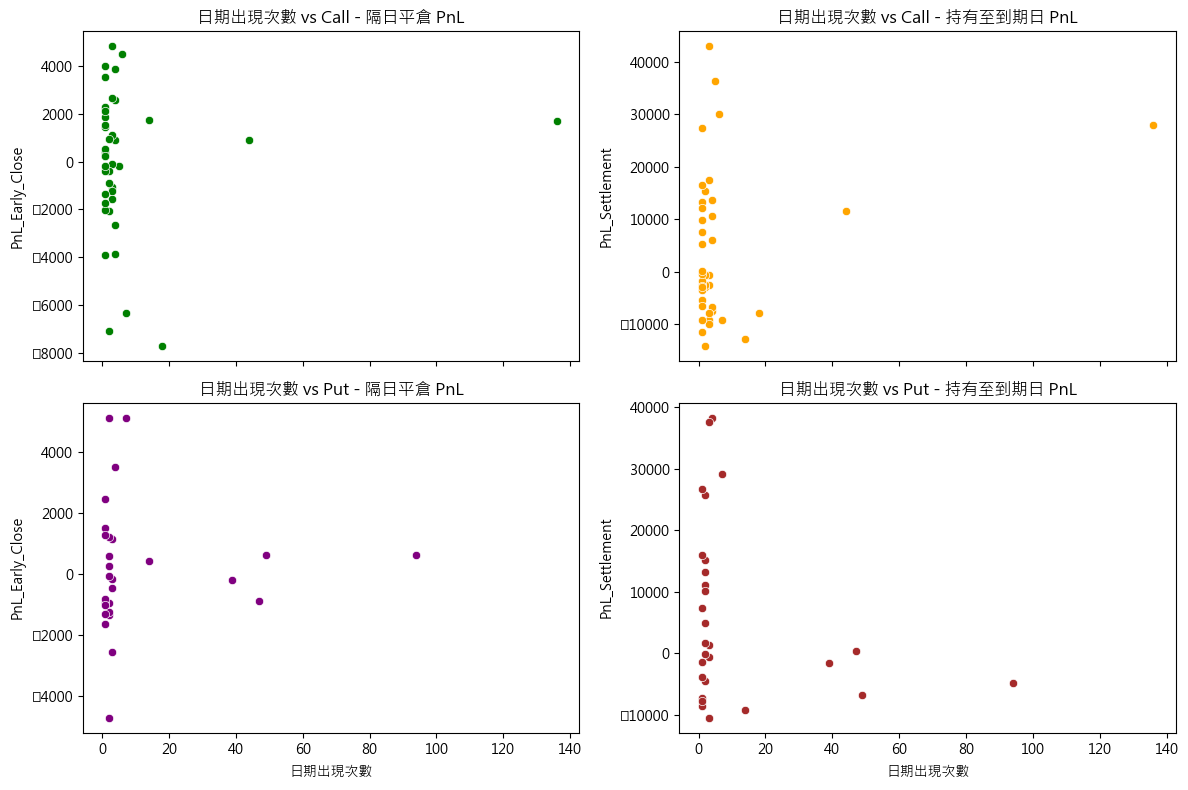

In [56]:
def analyze_option_date_performance(df):
    """ÂàÜÊûêÊó•ÊúüÂá∫ÁèæÊ¨°Êï∏Ëàá Call/Put ‰∫§ÊòìÂèäÂÖ∂Á∏æÊïàÈóú‰øÇ"""
    
    df = df.copy()
    
    # **Á¢∫‰øùÊï∏ÊìöÊ†ºÂºèÊ≠£Á¢∫**
    df["Date"] = pd.to_datetime(df["Date"])  
    df["SettlementDate"] = pd.to_datetime(df["SettlementDate"])
    df["PnL_Early_Close"] = pd.to_numeric(df["PnL_Early_Close"], errors="coerce")
    df["PnL_Settlement"] = pd.to_numeric(df["PnL_Settlement"], errors="coerce")

    # **Ë®àÁÆóÊó•ÊúüÂá∫ÁèæÊ¨°Êï∏**
    date_counts = df["Date"].value_counts().reset_index()
    date_counts.columns = ["Date", "Count"]
    
    # **ÊåâÊó•ÊúüË®àÁÆó Call & Put Êï∏Èáè**
    df_call = df[df["Category"] == "C"]
    df_put = df[df["Category"] == "P"]

    call_counts = df_call["Date"].value_counts().reset_index()
    call_counts.columns = ["Date", "Call_Count"]
    
    put_counts = df_put["Date"].value_counts().reset_index()
    put_counts.columns = ["Date", "Put_Count"]

    # **ÊåâÊó•ÊúüË®àÁÆó PnL**
    df_pnl = df.groupby(["Date", "Category"]).agg({
        "PnL_Early_Close": "mean",
        "PnL_Settlement": "mean"
    }).reset_index()

    return date_counts, call_counts, put_counts, df_pnl

def plot_option_date_relationship(date_counts, df_pnl):
    """Ë¶ñË¶∫Âåñ Êó•ÊúüÂá∫ÁèæÊ¨°Êï∏ vs Call/Put PnL Ë°®Áèæ"""

    fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

    # **Êó•ÊúüÂá∫ÁèæÊ¨°Êï∏ vs Call - ÈöîÊó•Âπ≥ÂÄâ PnL**
    sns.scatterplot(x=date_counts["Count"], 
                    y=df_pnl[df_pnl["Category"] == "C"]["PnL_Early_Close"], ax=ax[0, 0], color="green")
    ax[0, 0].set_title("Êó•ÊúüÂá∫ÁèæÊ¨°Êï∏ vs Call - ÈöîÊó•Âπ≥ÂÄâ PnL")
    ax[0, 0].set_xlabel("Êó•ÊúüÂá∫ÁèæÊ¨°Êï∏")
    ax[0, 0].set_ylabel("PnL_Early_Close")

    # **Êó•ÊúüÂá∫ÁèæÊ¨°Êï∏ vs Call - ÊåÅÊúâËá≥Âà∞ÊúüÊó• PnL**
    sns.scatterplot(x=date_counts["Count"], 
                    y=df_pnl[df_pnl["Category"] == "C"]["PnL_Settlement"], ax=ax[0, 1], color="orange")
    ax[0, 1].set_title("Êó•ÊúüÂá∫ÁèæÊ¨°Êï∏ vs Call - ÊåÅÊúâËá≥Âà∞ÊúüÊó• PnL")
    ax[0, 1].set_xlabel("Êó•ÊúüÂá∫ÁèæÊ¨°Êï∏")
    ax[0, 1].set_ylabel("PnL_Settlement")

    # **Êó•ÊúüÂá∫ÁèæÊ¨°Êï∏ vs Put - ÈöîÊó•Âπ≥ÂÄâ PnL**
    sns.scatterplot(x=date_counts["Count"], 
                    y=df_pnl[df_pnl["Category"] == "P"]["PnL_Early_Close"], ax=ax[1, 0], color="purple")
    ax[1, 0].set_title("Êó•ÊúüÂá∫ÁèæÊ¨°Êï∏ vs Put - ÈöîÊó•Âπ≥ÂÄâ PnL")
    ax[1, 0].set_xlabel("Êó•ÊúüÂá∫ÁèæÊ¨°Êï∏")
    ax[1, 0].set_ylabel("PnL_Early_Close")

    # **Êó•ÊúüÂá∫ÁèæÊ¨°Êï∏ vs Put - ÊåÅÊúâËá≥Âà∞ÊúüÊó• PnL**
    sns.scatterplot(x=date_counts["Count"], 
                    y=df_pnl[df_pnl["Category"] == "P"]["PnL_Settlement"], ax=ax[1, 1], color="brown")
    ax[1, 1].set_title("Êó•ÊúüÂá∫ÁèæÊ¨°Êï∏ vs Put - ÊåÅÊúâËá≥Âà∞ÊúüÊó• PnL")
    ax[1, 1].set_xlabel("Êó•ÊúüÂá∫ÁèæÊ¨°Êï∏")
    ax[1, 1].set_ylabel("PnL_Settlement")

    plt.tight_layout()
    plt.show()



date_counts, call_counts, put_counts, df_pnl = analyze_option_date_performance(df_new_2)
plot_option_date_relationship(date_counts, df_pnl)